# Rival

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from data import Tweets

## 1. Get data

In [6]:
tweets = Tweets('nosilverv')
tweets.run()

Daily tweet counts:

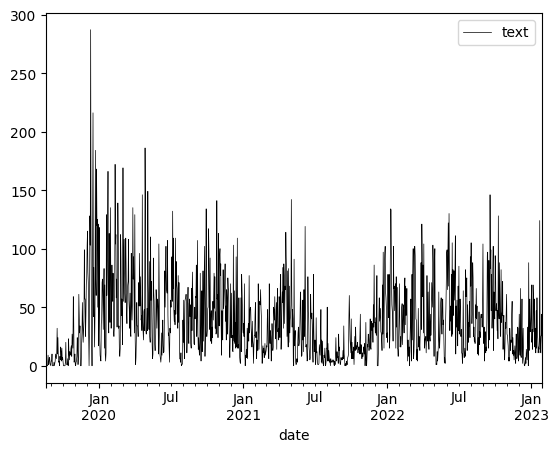

In [40]:
tweets.data.groupby('date').count().resample('D').sum().plot(c = 'k', lw = .5);

Tweet count vs hour of day (UTC):

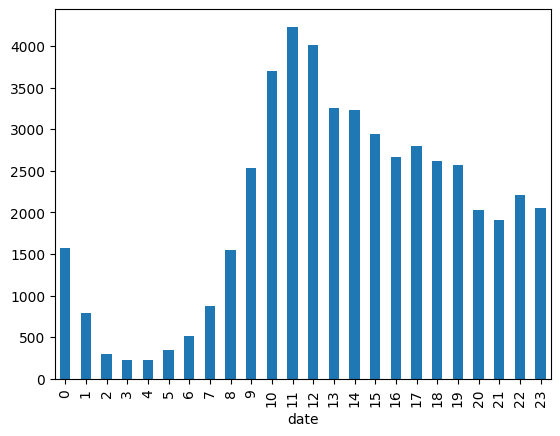

In [67]:
tweets.data.groupby(tweets.data.date.dt.hour).size().plot.bar();

## 2. Models

* https://huggingface.co/models
* https://arxiv.org/pdf/1703.01488.pdf
* http://proceedings.mlr.press/v22/hennig12/hennig12.pdf
* https://num.pyro.ai/en/stable/examples/prodlda.html
* https://www.sbert.net/examples/applications/computing-embeddings/README.html
* https://www.sbert.net/examples/applications/clustering/README.html
* https://github.com/ddangelov/Top2Vec
    * https://colab.research.google.com/drive/1xno60XzyJgVhcjXnKai40ltuSNDNPAqq?usp=sharing#scrollTo=35-7CcVz1CJa

In [ ]:
# dropna
# remove @usernames
# remove special characters
# remove common words for BoW model

In [ ]:
# bert
# sbert
# openai models
# sentiment vs time

In [69]:
from top2vec import Top2Vec

model = Top2Vec(documents = list(tweets.data.text), speed = 'learn', workers = 8)

In [137]:
model.get_num_topics()

140

In [138]:
model.get_topic_sizes()

(array([1054,  892,  820,  808,  798,  797,  784,  755,  717,  710,  708,
         676,  643,  638,  610,  604,  597,  587,  581,  575,  563,  558,
         520,  515,  512,  507,  503,  494,  484,  482,  479,  451,  443,
         440,  430,  429,  413,  403,  402,  399,  381,  379,  377,  363,
         352,  339,  332,  328,  320,  315,  311,  303,  301,  301,  291,
         287,  275,  265,  256,  250,  248,  238,  238,  237,  237,  236,
         234,  227,  217,  209,  203,  202,  202,  195,  192,  192,  189,
         187,  181,  175,  172,  170,  167,  166,  166,  160,  157,  154,
         152,  141,  140,  137,  136,  132,  130,  127,  125,  124,  124,
         122,  121,  121,  121,  117,  117,  110,  110,  108,  107,  105,
         102,  102,  101,  100,  100,  100,   98,   94,   93,   91,   89,
          89,   89,   86,   85,   84,   78,   78,   75,   75,   74,   73,
          70,   70,   70,   70,   67,   61,   55,   51]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  

In [139]:
model.get_topics(5)

(array([['ratio', 'jose_goncalves_', 'nstinct', 'sell', 'maybegray',
         'averykimball', 'blocked', 'house', 'liminal_warmth', 'girl',
         'jesscamp', 'romeostevens', 'hot', 'retweet', 'blog', 'boys',
         'please', 'threadhelper', 'avi', 'threads', 'girls',
         'hifrommichaelv', 'swear', 'english', 'mechanical_monk',
         'comment', 'jack', 'rival', 'seanmombo', 'alt', 'joking', 'rat',
         'adult', 'lucid', 'virgin', 'boy', 'conaw', 'page', 'de',
         'practice', 'link', 'followers', 'territory', 'epistemichope',
         'woman', 'knuckles', 'peligrietzer', 'nuanceexists', 'year',
         'map'],
        ['bile', 'chad', 'winning', 'sorry', 'rerarom', 'pyeerk',
         'blessed', 'owned', 'geniesloki', 'incredible', 'wanting', 'or',
         'example', 'paying', 'nstinct', 'the', 'reverse',
         'understanding', 'peligrietzer', 'call', 'people', 'and',
         'becoming', 'serve', 'oh', 'dreaming', 'danlistensto', 'virgin',
         'kid', 'mayb